In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


## SubEnvironment

This environment models a single asset that oscillates via Sine wave with optional noise.  The asset fluctuates in value, and the agent must either hold (not do anything) or invest in the asset.

The reward is based on the agent's decision and the value of the asset.  If the decision is to hold, then the reward is 0.  If the decision is to invest, then the reward is equal to the value.  The value can range from -1 to 1.

Ideally, the agent will properly forecast the next timestep's value, and choose to hold if it's negative and to invest if it's positive.

In [26]:
class SubEnvironment:
    def __init__(self, lookback=10, max_steps=100, noise=0, seed=None):
        # how much of the value history the agent sees
        self.lookback = lookback
        
        # available actions (hold/invest)
        self.action_space = gym.spaces.Discrete(2)
        
        # observation space (lookback)
        self.observation_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(self.lookback,), dtype=np.float32)
        
        # how long an episode lasts
        self.max_steps = max_steps
        
        # noise to apply to the value
        self.noise = noise
        
        # set a seed for testing
        self.seed = seed
        
    def reset(self, seed=None):
        if self.seed:
            np.random.seed(self.seed)
        if seed:
            np.random.seed(seed)
            
        # The current timestep
        self.t = self.lookback
        
        # The rewards of the episode
        self.current_reward = 0.
        self.episode_rewards = [self.current_reward]
        
        # Our "time" space
        self.x_space = np.arange(self.max_steps)
        
        # Our "asset" space
        a_c = np.random.randint(2,17)
        self.a_space = np.sin(np.linspace(0,a_c*np.pi,self.max_steps))
        self.a_space += np.random.normal(0, self.noise, size=self.a_space.shape)
        self.a_space = np.clip(self.a_space, -1., 1.)
        
        # The current "viewable" observation
        self.observation = self.a_space[self.t-self.lookback:self.t]
        
        # The current position of the agent (0: neutral, 1: long)
        self.position = 0
        
        return self.observation.reshape(self.observation_space.shape)
    
    def step(self, action):
        # increment time
        self.t += 1
        
        # update observation
        self.observation = self.a_space[self.t-self.lookback:self.t]
        
        # our current asset value
        current = self.observation[-1]
        
        # our current position
        self.position = action
        
        # the reward for our position
        # e.g., if our position == 0 (neutral), then we gain no reward
        # if our position == 1 (long), then we gain/lose the change
        instantaneous_reward = self.position * current
        self.current_reward += instantaneous_reward
        self.episode_rewards.append(self.current_reward)
        
        done = False
        if self.t >= self.max_steps - 1:
            done = True
            
        return self.observation.reshape(self.observation_space.shape), instantaneous_reward, done, {}
    
    def render(self):
        fig, ax = plt.subplots(1,2,figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

        ax[0].plot(self.x_space, self.a_space)
        ax[0].plot([self.t], [self.a_space[self.t]], 'ro')
        ax[1].plot(self.episode_rewards)

        plt.show()

Next, we test the subenvironment.  Here, we take random actions after every step and plot every 10 steps.

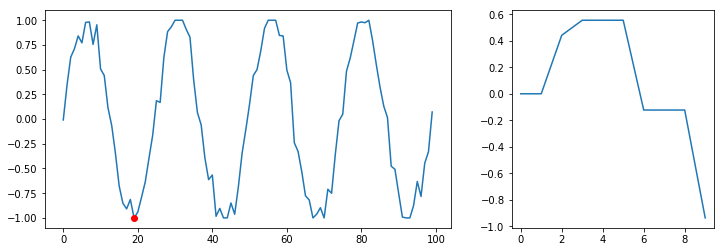

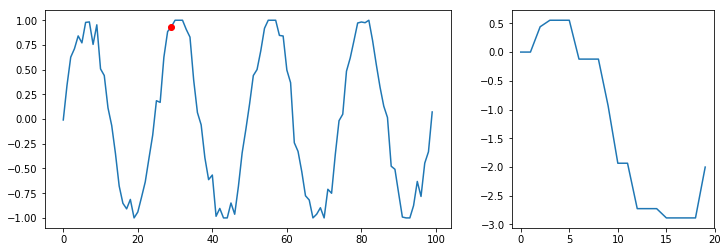

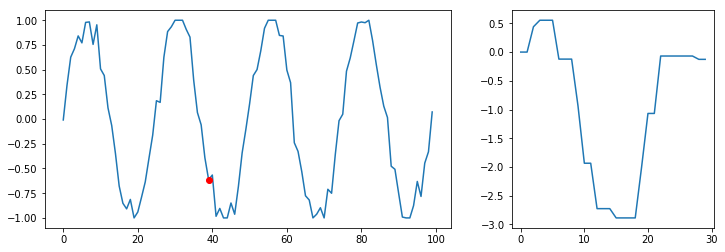

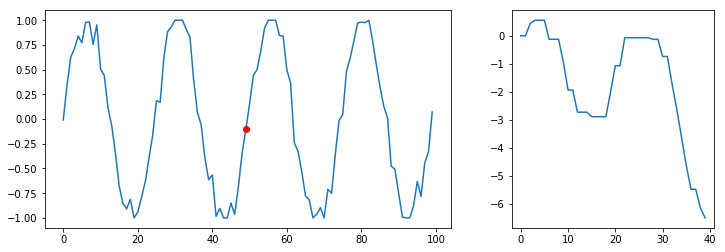

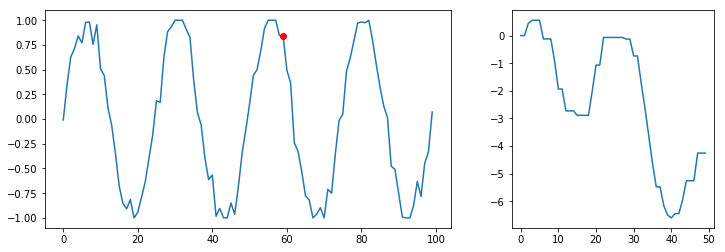

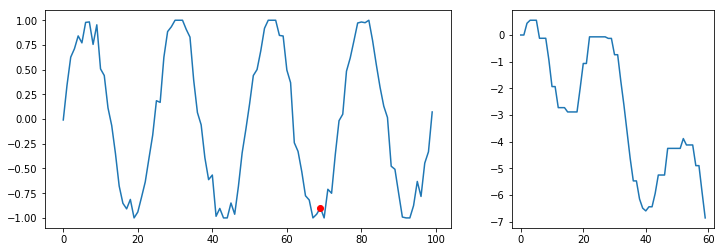

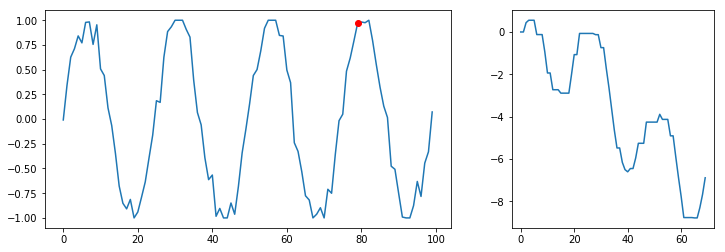

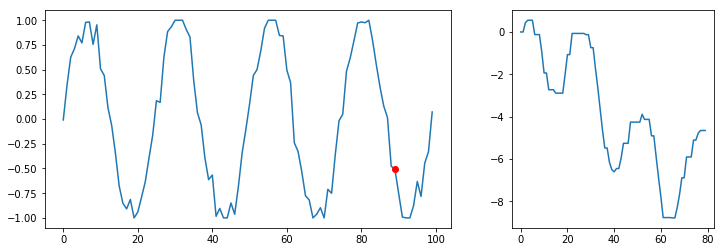

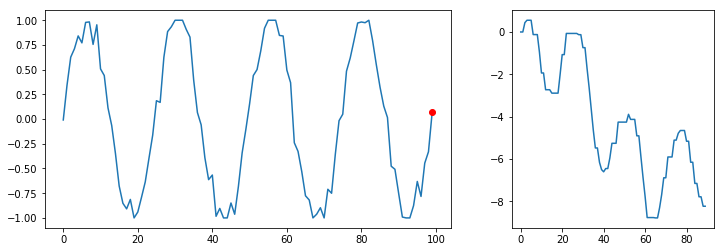

In [27]:
env = SubEnvironment(noise=0.1)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, rew, done, info = env.step(action)
    if (env.t + 1) % 10 == 0:
        env.render()

#### SubAgent

Here, we define the sub-agent.  This is simply a PPO agent with no modifications.

In [50]:
class SubAgent:
    def __init__(self, env,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        # K.clear_session()
        self.env = env
        
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 
        self.critic = self.build_critic()
        
        # When we want predictions of actions, we need to pass in three things:
        # the observation, the old prob, and the advantage.
        # Here, we just created data to spoof the last two.
        self.DUMMY_ACTION, self.DUMMY_VALUE = np.zeros((1,self.action_space.n)), np.zeros((1,1))

    def proximal_policy_optimization_loss(self, advantage, old_pred, debug=True):
        
        # Defines the PPO loss to be used during actor optimization
        def loss(y_true, y_pred):
            
            # advantage is a vector of size 1 passed in from the critic
            # This summing flattens it
            adv = K.sum(advantage, axis=1)
            if debug:
                adv = K.print_tensor(adv, 'advantage     :')

            # y_true is one-hot vector denoting the action taken
            # y_pred is the output of the actor neural network
            # for the given observation
            # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
            # so prob = y_true * y_pred = [0, 0.5, 0]
            if debug:
                y_true = K.print_tensor(y_true, 'y_true        :')
                y_pred = K.print_tensor(y_pred, 'y_pred        :')
                
            prob = y_true * y_pred
            if debug:
                prob = K.print_tensor(prob, 'prob          :')

            # old_pred is the actor's previous probabilty distribution
            # for the given observation
            # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
            # so prob = y_true * old_pred = [0, 0.4, 0]
            old_prob = y_true * old_pred
            if debug:
                old_prob = K.print_tensor(old_prob, 'old_prob      :')

            # r is the ratio of the old probability to the new one
            # e.g., r = prob/old_prob = [0, 0.5/0.4, 0]
            r = K.sum(prob/(old_prob + 1e-10), axis=1)
            if debug:
                r = K.print_tensor(r, 'r             :')

            # clipped is the value of r clipped between 1 +/- epsilon
            # e.g., r = 1.4, epsilon = 0.2 => clipped = 1.2
            clipped = K.clip(r, min_value=1-self.epsilon, max_value=1+self.epsilon)
            if debug:
                clipped = K.print_tensor(clipped, 'clipped       :')

            # minimum is the min of r * advantage and clipped * advantage
            minimum = K.minimum(r * adv, clipped * adv)
            if debug:
                minimum = K.print_tensor(minimum, 'minimum       :')

            # entropy bonus (to encourage exploration)
            entropy_bonus = self.entropy_loss * (prob * K.log(prob + 1e-10))
            entropy_bonus = K.sum(entropy_bonus, axis=1)
            if debug:
                entropy_bonus = K.print_tensor(entropy_bonus, 'entropy_bonus :')

            # K.mean computes the mean over all dimensions (left with a scaler)
            result = -K.mean(minimum + entropy_bonus)
            if debug:
                result = K.print_tensor(result, 'result        :')

            return result
        return loss
    
    def build_actor(self):
        # actor has three inputs: the current state, the advantage,
        # and the agent's predicted probability for the given observation
        state_inputs = Input(shape=self.observation_space.shape)
        advantage = Input(shape=(1,))
        old_pred = Input(shape=(self.action_space.n,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # the output is a probability distribution over the actions
        out_actions = Dense(self.action_space.n, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_pred],
                      outputs=[out_actions])
        
        # compile the model using our custom loss function
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_pred=old_pred
                      )])
        return model
    
    def build_critic(self):
        # critic recieves the observation as input
        state_inputs = Input(shape=self.observation_space.shape)
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # we predict the value of the current observation
        # i.e., cumulative discounted reward
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict([np.array([observation]), 
                                   self.DUMMY_VALUE, 
                                   self.DUMMY_ACTION])
        prob = prob.flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.action_space.n, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.action_space.n)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_probs = probs
        
        # Calculate advantages
        values = self.critic.predict(obs).reshape((self.buffer_size, 1))
        advs = rews - values
            
        # Train the actor and critic on the batch data
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=self.batch_size, shuffle=True,
                        epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False):
        episode = 0
        reward_history = []

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                action, action_vector, prob = self.get_action(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(action)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['action_vector'].append(action_vector)
                tmp_batch['probability'].append(prob)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                        tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        act = tmp_batch['action_vector'][i]
                        prob = tmp_batch['probability'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['action_vector'].append(act)
                        batch['probability'].append(prob)
                        batch['reward'].append(r)

                    # every 10th episode, log some stuff
                    if (episode+1) % 10 == 0 and verbose:
                        print('Episode:', episode)
                        print('Reward :', reward_data)
                        print('Average:', np.mean(reward_history[-100:]))
                        print('-'*10)
                        print()

                        env.render()
                
                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'action_vector': [],
                        'probability': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1

            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['action_vector'])
            probabilities = np.array(batch['probability'])
            rewards = np.array(batch['reward'])    
            rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, probabilities, rewards)
                    
        self.reward_history = reward_history
        return self.reward_history

## Training SubAgents

Here, we demonstrate how the subagents can be trained to "trade" the assets so as to maximize "profit."

Episode: 9
Reward : 6.725750545199771
Average: 0.6409008936795055
----------



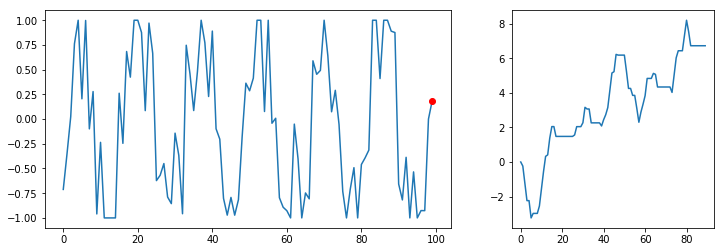

Episode: 19
Reward : -5.068487478488724
Average: 2.6370262237584337
----------



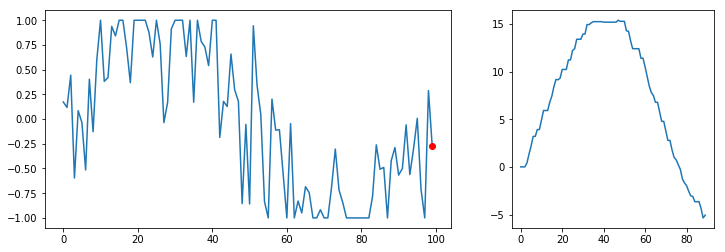

Episode: 29
Reward : 5.726462872047657
Average: 2.259929651543781
----------



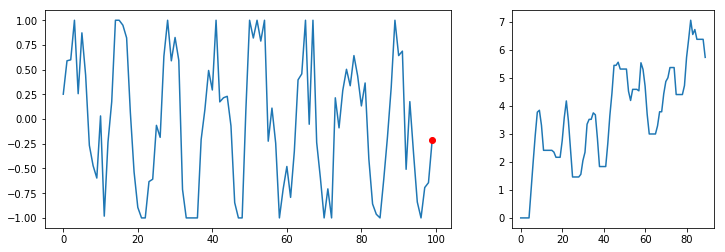

Episode: 39
Reward : 4.889836203236694
Average: 3.242774819214528
----------



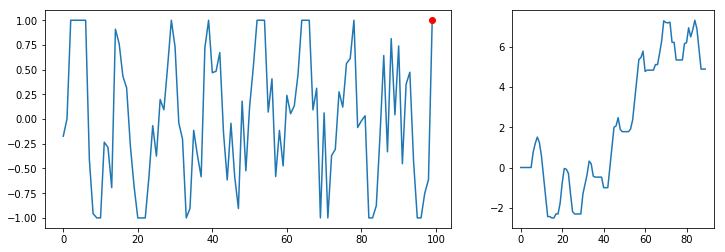

Episode: 49
Reward : 10.904848604272274
Average: 4.0437017310786825
----------



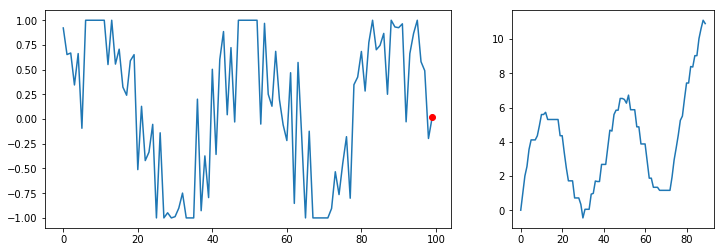

Episode: 59
Reward : 11.010965053543218
Average: 4.635773845982154
----------



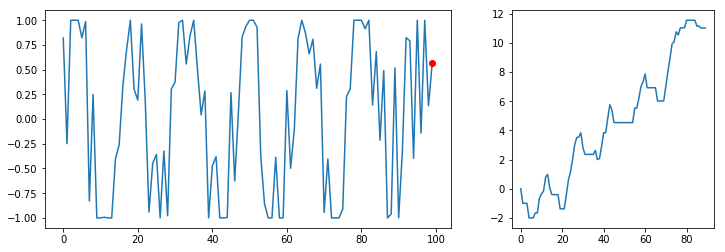

Episode: 69
Reward : 8.824530201927647
Average: 5.335296173493753
----------



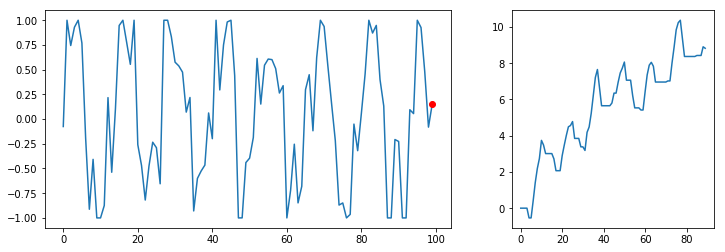

Episode: 79
Reward : 2.5843136205180532
Average: 6.032799251695164
----------



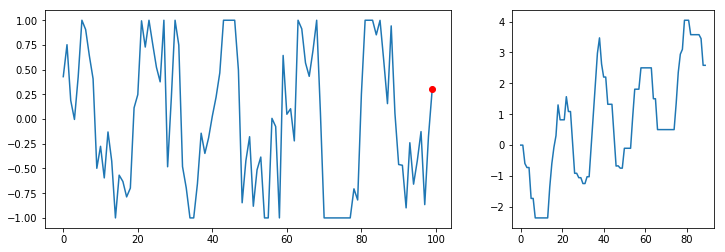

Episode: 89
Reward : 8.29517484505993
Average: 6.180051738913174
----------



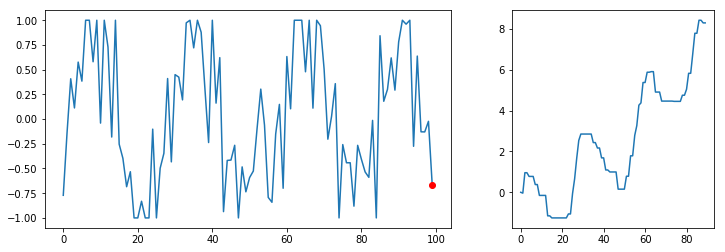

Episode: 99
Reward : 6.290380626161302
Average: 6.50444421393411
----------



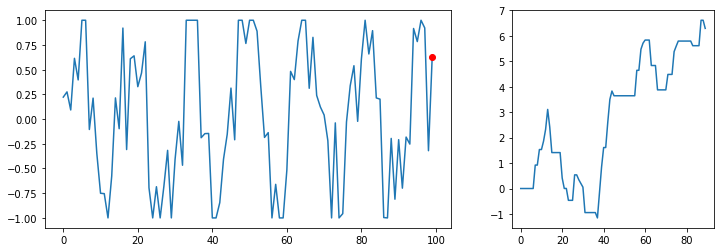

Episode: 109
Reward : 7.597336126093714
Average: 7.494387950217819
----------



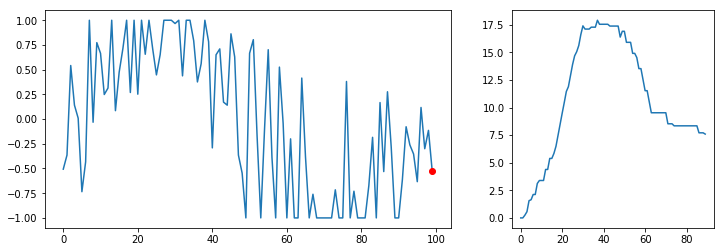

Episode: 119
Reward : 14.158676632095853
Average: 8.203096084127324
----------



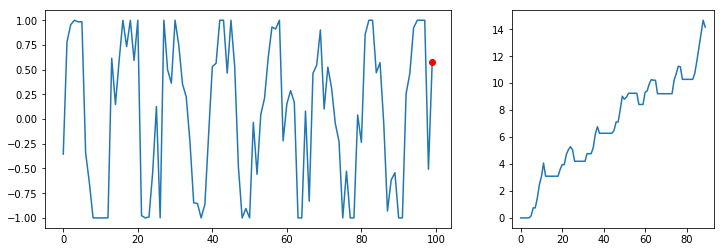

Episode: 129
Reward : 6.846607628348412
Average: 9.09985559488858
----------



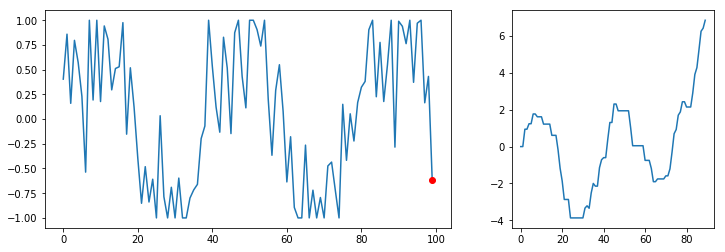

Episode: 139
Reward : 11.846849828880085
Average: 9.581014552278415
----------



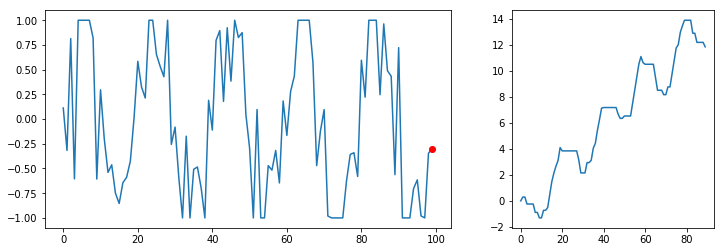

Episode: 149
Reward : 6.160647443852065
Average: 9.849148294612732
----------



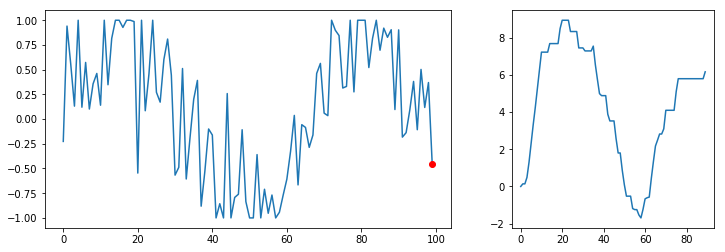

Episode: 159
Reward : 21.63410747117528
Average: 10.36410488063428
----------



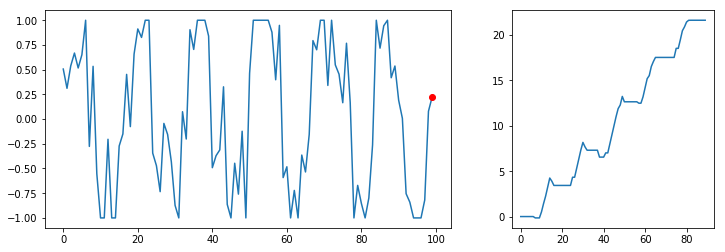

Episode: 169
Reward : 7.853190283163271
Average: 10.611566539972737
----------



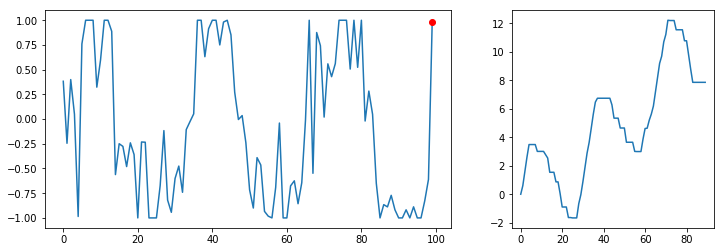

Episode: 179
Reward : 17.33015537984294
Average: 10.94418342887079
----------



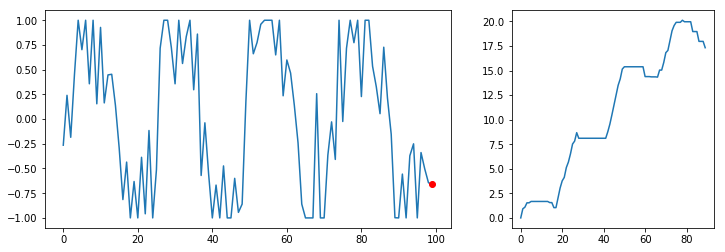

Episode: 189
Reward : 15.134946810985916
Average: 11.817937473690677
----------



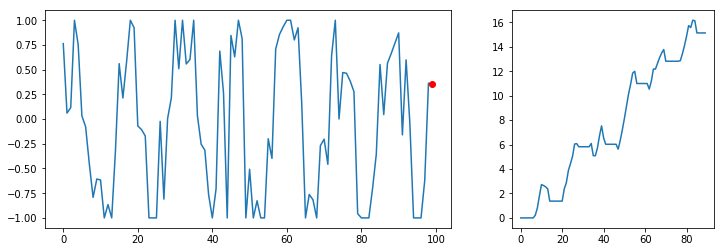

Episode: 199
Reward : 12.241993052370757
Average: 12.609361711385546
----------



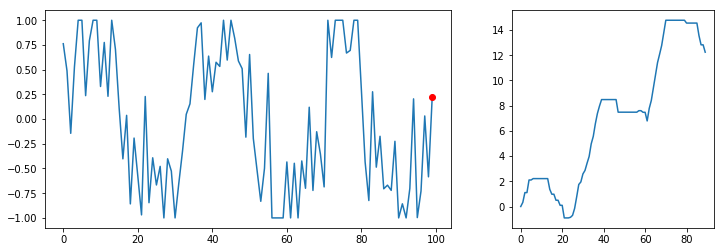

Episode: 209
Reward : 16.57626027809831
Average: 13.15923039639554
----------



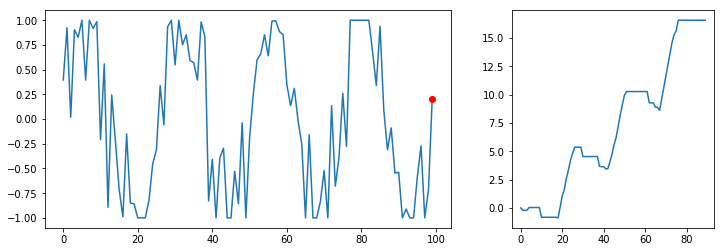

Episode: 219
Reward : 16.8884843907086
Average: 13.62749929711299
----------



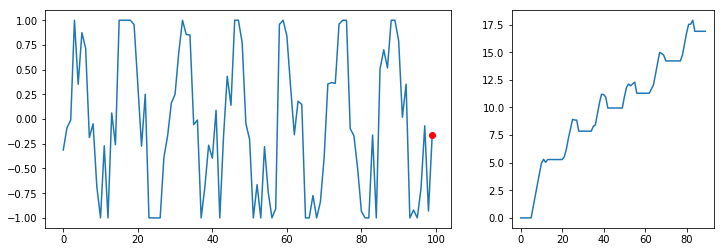

Episode: 229
Reward : 8.34392078310662
Average: 14.001692360781313
----------



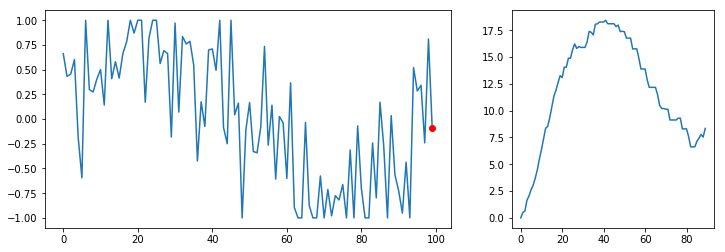

Episode: 239
Reward : 13.297942804464455
Average: 14.581931949964666
----------



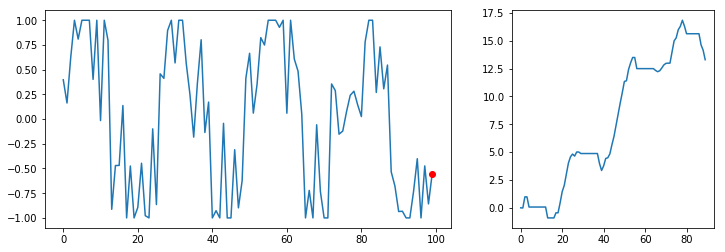

Episode: 249
Reward : 20.015493529977462
Average: 15.455155880502893
----------



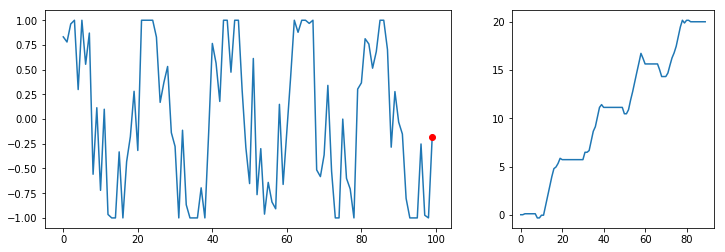

Episode: 259
Reward : 18.147107293481554
Average: 16.042862476912898
----------



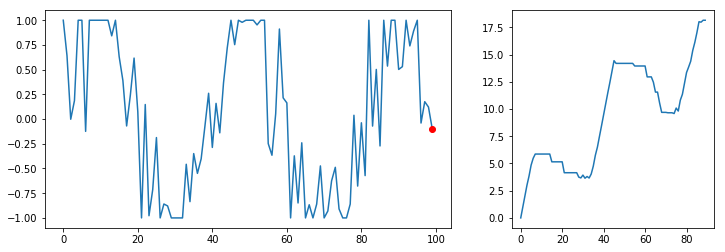

Episode: 269
Reward : 12.33260872272518
Average: 16.152773396557286
----------



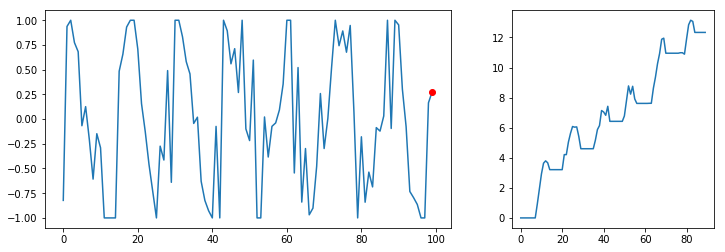

Episode: 279
Reward : 21.277842273124154
Average: 16.443154381754095
----------



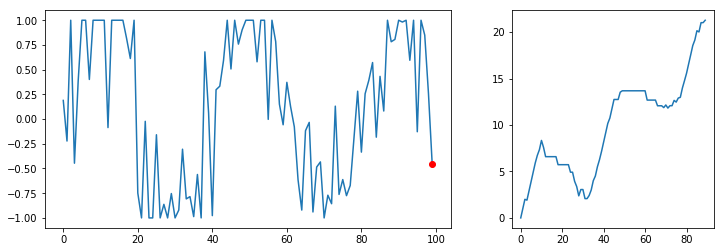

Episode: 289
Reward : 20.064719498898867
Average: 16.70720260748508
----------



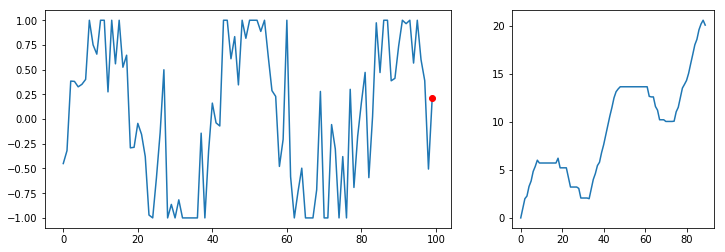

Episode: 299
Reward : 14.728252972972081
Average: 16.66302085601525
----------



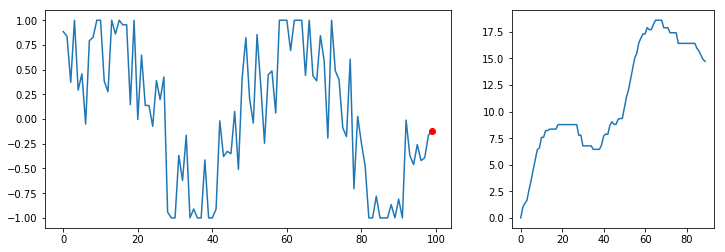

Episode: 309
Reward : 10.003125563396662
Average: 16.78975038897371
----------



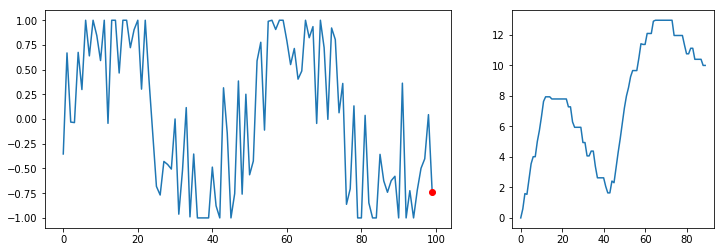

Episode: 319
Reward : 19.330986707754146
Average: 16.85341155503854
----------



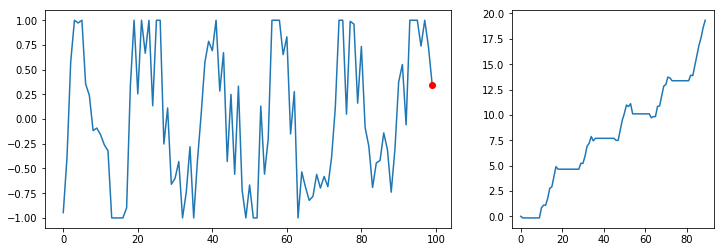

Episode: 329
Reward : 11.342027109249791
Average: 17.14198801768514
----------



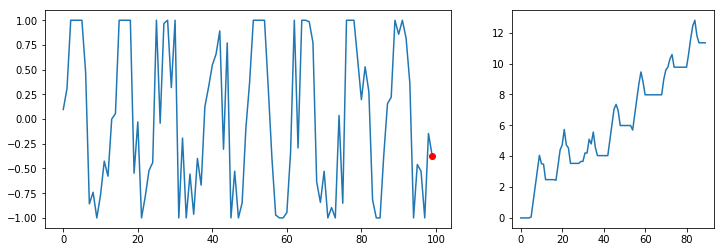

Episode: 339
Reward : 13.196818900617115
Average: 17.096423497728562
----------



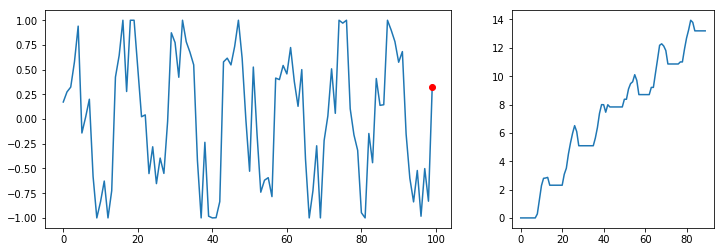

Episode: 349
Reward : 17.395565304546864
Average: 17.06952139468392
----------



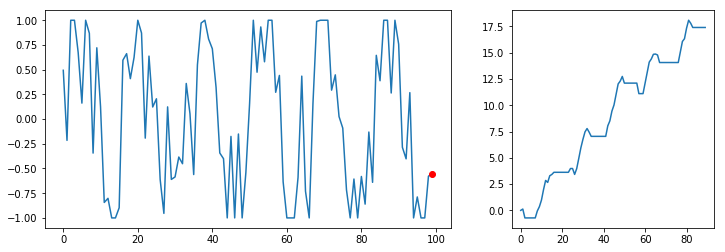

Episode: 359
Reward : 8.586740834663317
Average: 16.751172876840272
----------



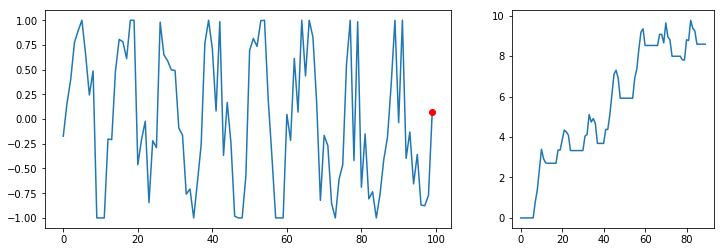

Episode: 369
Reward : 23.217236154128624
Average: 17.212881567912085
----------



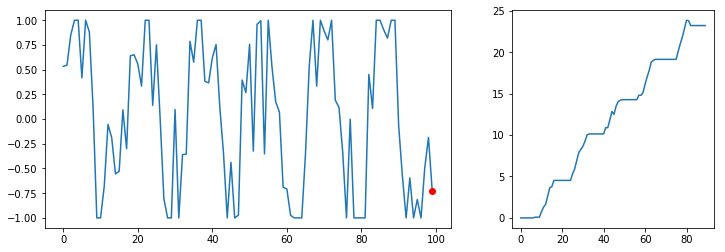

Episode: 379
Reward : 10.401642858481962
Average: 17.026695379368537
----------



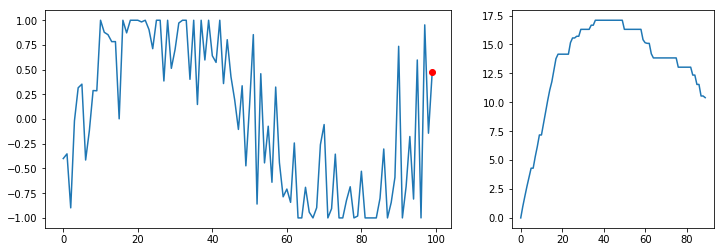

Episode: 389
Reward : 16.50580668311569
Average: 16.674526067078318
----------



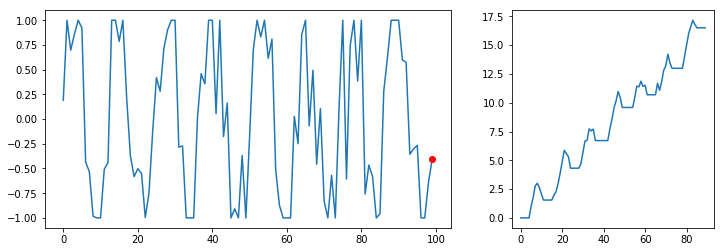

Episode: 399
Reward : 12.033274184139287
Average: 16.581798084026254
----------



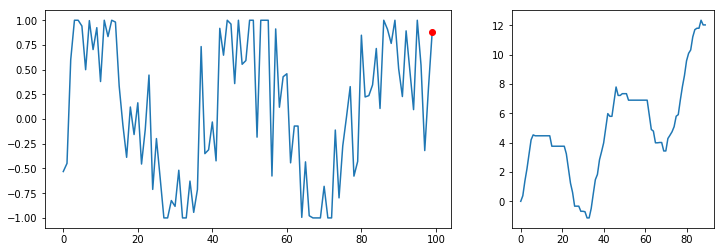

Episode: 409
Reward : 20.279044094618875
Average: 16.6433776274488
----------



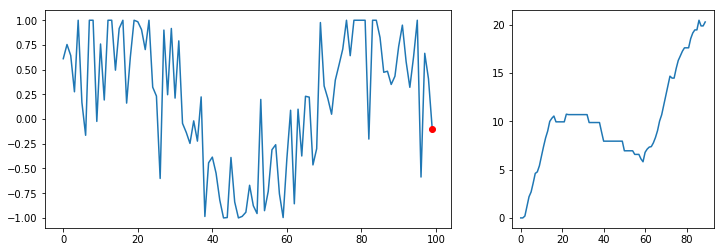

Episode: 419
Reward : 7.783261505227016
Average: 16.453599679278962
----------



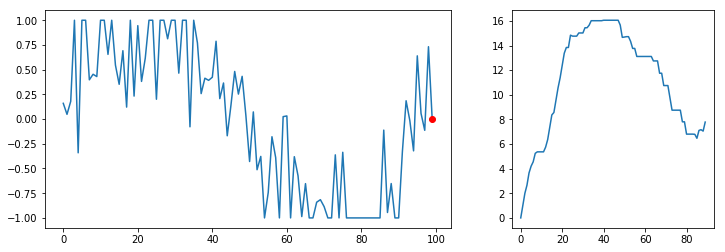

Episode: 429
Reward : 17.090115736728798
Average: 15.865306270301694
----------



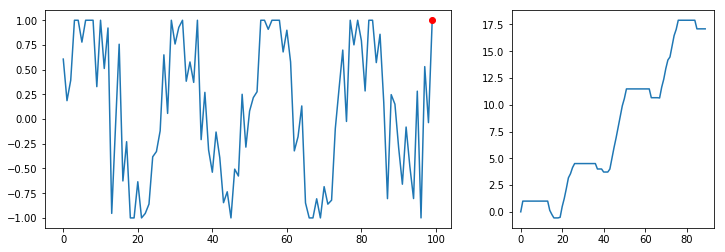

Episode: 439
Reward : 10.998759665233695
Average: 15.594753820889641
----------



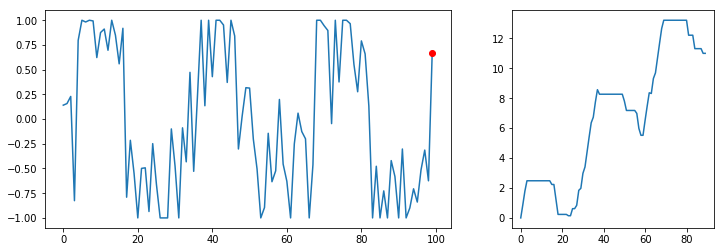

Episode: 449
Reward : 16.27030983243597
Average: 15.510573139586443
----------



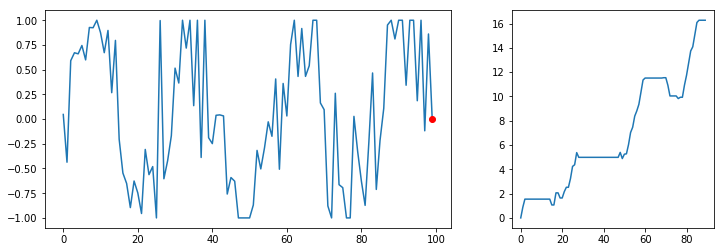

Episode: 459
Reward : 19.12291757058617
Average: 15.486383072155197
----------



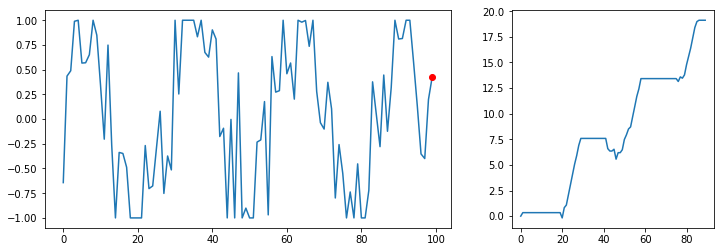

Episode: 469
Reward : 18.65873953230327
Average: 15.546334638531185
----------



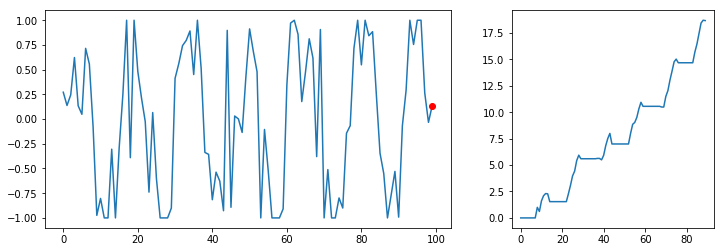

Episode: 479
Reward : 10.09712818182464
Average: 15.334564936064378
----------



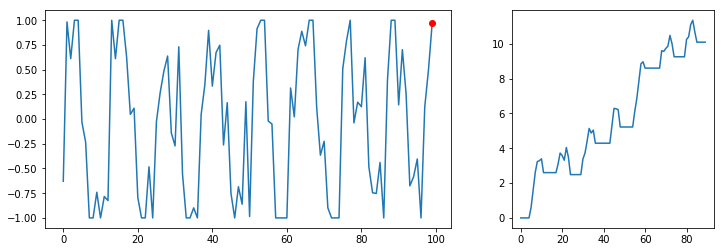

Episode: 489
Reward : 19.642298866741974
Average: 15.056844474282991
----------



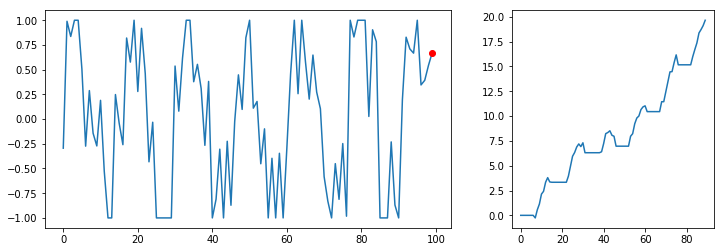

Episode: 499
Reward : 15.518582415452752
Average: 14.851456060773158
----------



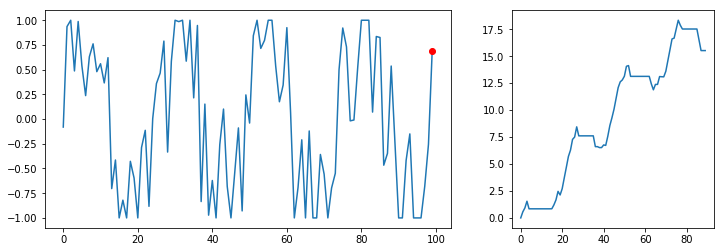

In [7]:
env = SubEnvironment(noise=0.5)
agent = SubAgent(env=env)
rh = agent.run(env, 500, verbose=True)

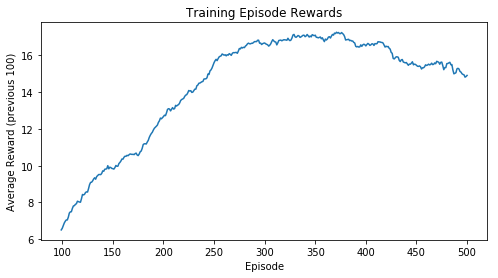

In [16]:
rh_mean = pd.Series(rh).rolling(100).mean()
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_title('Training Episode Rewards')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward (previous 100)')
ax.plot(rh_mean)

plt.show()

Here, we test our trained subagent on a seeded environment.

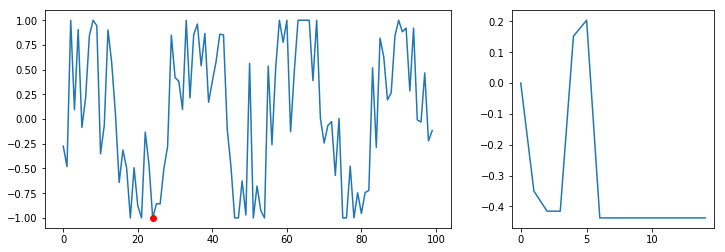

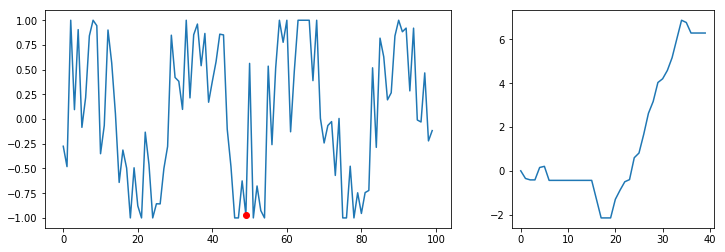

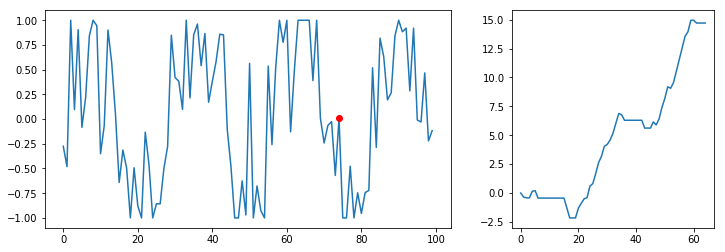

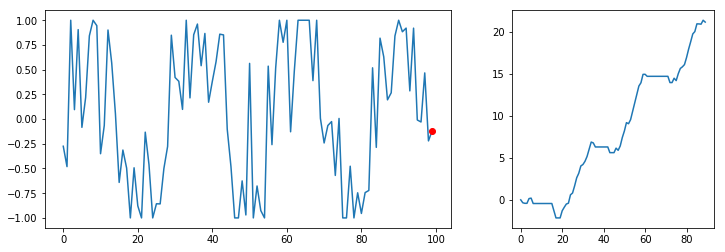

Reward: 21.15800482684643


In [19]:
env = SubEnvironment(seed=1, noise=0.5)
obs = env.reset()
done = False
reward = 0
while not done:
    action = agent.get_action(obs)[0]
    obs, rew, done, info = env.step(action)
    reward += rew
    if (env.t + 1) % 25 == 0:
        env.render()
        
print('Reward:', reward)

Then, for comparison, we test the same environment as above on an untrained agent.

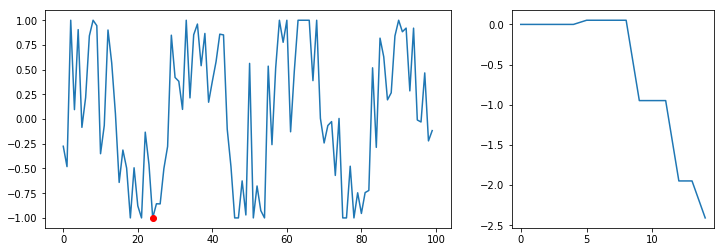

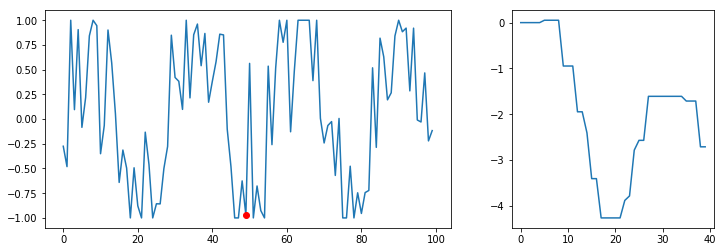

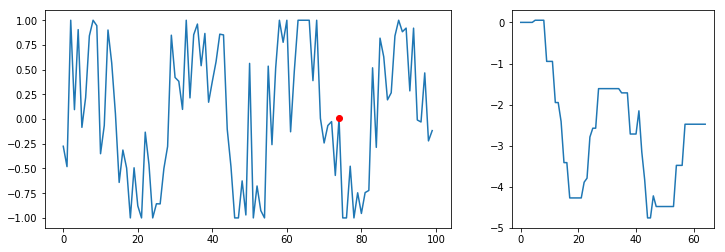

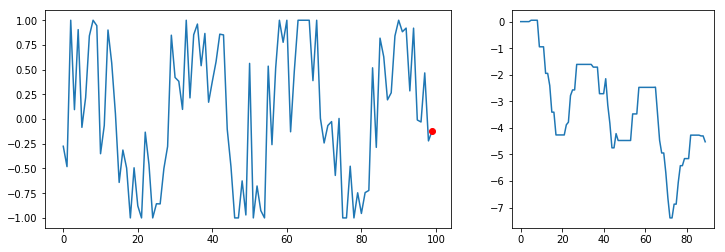

Reward: -4.523471634151065


In [21]:
env = SubEnvironment(seed=1, noise=0.5)
untrained_agent = SubAgent(env=env)
obs = env.reset()
done = False
reward = 0
while not done:
    action = untrained_agent.get_action(obs)[0]
    obs, rew, done, info = env.step(action)
    reward += rew
    if (env.t + 1) % 25 == 0:
        env.render()
        
print('Reward:', reward)

As we can see, the trained agent performs considerably better than the untrained agent.  Granted, the task is relatively easy, but the main point is that our subagents can perform better on the environment than a random agent.

## MetaEnvironment

Next, we create the MetaEnvironment, which acts as a higher level environment for organizing a collect of subenvironments.

In [63]:
class MetaEnvironment:
    def __init__(self, envs, friction=0., seed=None):
        self.envs = envs
        self.env_count = len(envs)
        
        self.sub_action_space = envs[0].action_space
        self.sub_observation_space = envs[0].observation_space
        
        self.action_space = gym.spaces.Box(low=0.0, high=1.0, shape=(self.env_count,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1.0, high=1.0,
                                                shape=self.sub_observation_space.shape + (1,),
                                                dtype=np.float32)
        self.agents = []
        for env in self.envs:
            self.agents.append(SubAgent(env))
        
        self.friction = friction
        self.seed = seed
        
    def reset(self):
        self.allocation = np.ones(shape=(self.env_count,))
        self.allocation /= np.sum(self.allocation)
        self.previous_allocation = self.allocation
        
        observations = []
        rewards = []
        for env in self.envs:
            obs = env.reset()
            rewards.append(0)
            observations.append(obs)
            
        self.observations = np.array(observations)
        self.rewards = np.array(rewards)
        self.episode_rewards = [0.]
        return self.observations
    
    def step(self, allocation):
        self.allocation = allocation
        observations = []
        rewards = []
        
        done = False
        for i, env in enumerate(self.envs):
            _action = self.agents[i].get_action(self.observations[i])[0]
            _obs, _rew, _done, _info = env.step(_action)
            rewards.append(_rew)
            observations.append(_obs)
            done = _done

        self.observations = np.array(observations)
        cost = self.friction*abs(self.previous_allocation - self.allocation)
        rewards -= cost
        self.rewards = np.array(rewards)
        self.previous_allocation = self.allocation
            
        self.episode_rewards.append(np.sum(self.rewards))
        return self.observations, self.rewards, done, {}

    def render(self):
        for i, env in enumerate(self.envs):
            print('Sub {}'.format(i))
            env.render()
            
        fig, ax = plt.subplots(1,2,figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

        ax[0].set_ylim(0,1)
        ax[0].bar(range(self.env_count), self.allocation)
        ax[1].plot(self.episode_rewards)

        print("Meta")
        plt.show()

Sub 0


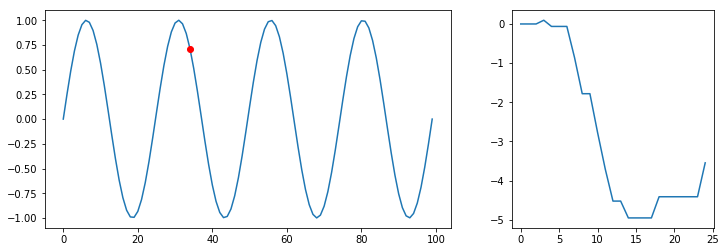

Sub 1


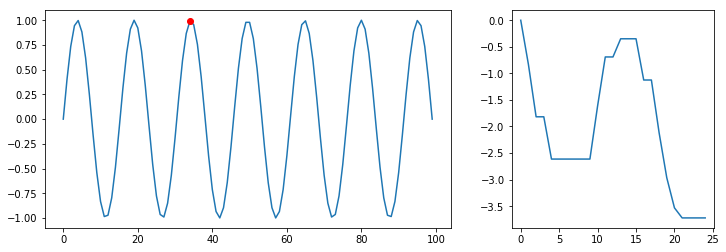

Sub 2


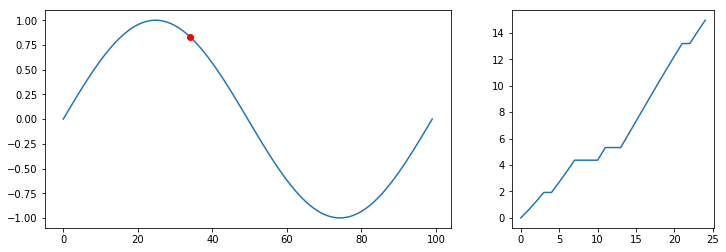

Meta


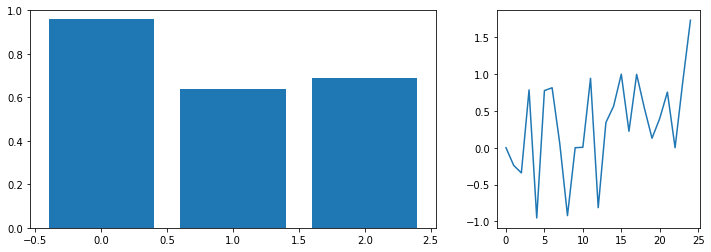

Sub 0


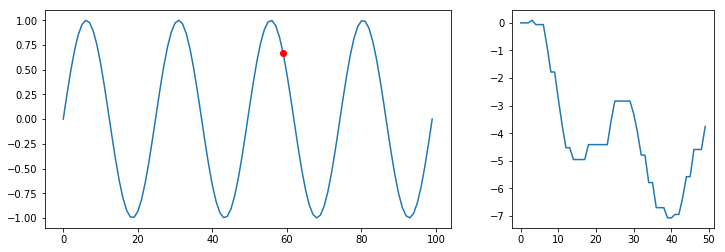

Sub 1


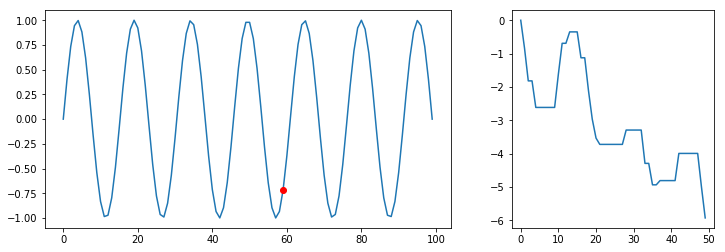

Sub 2


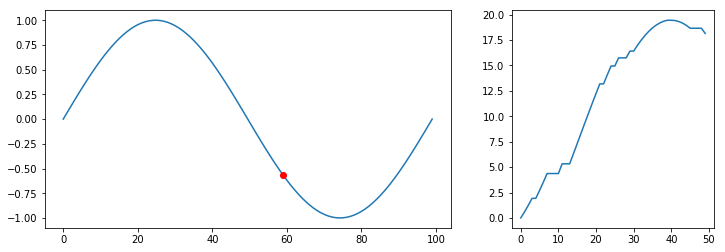

Meta


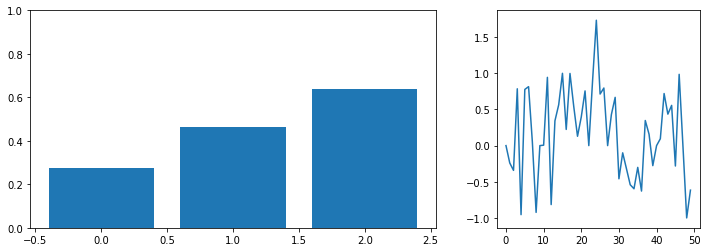

Sub 0


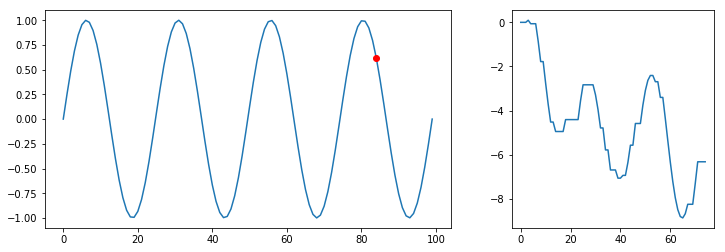

Sub 1


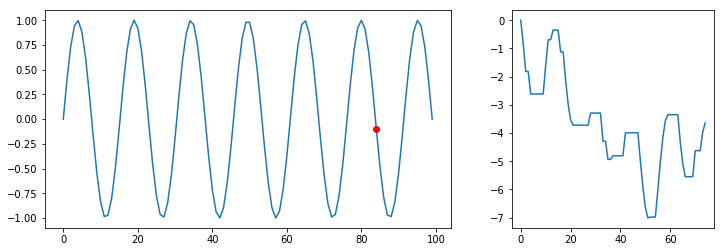

Sub 2


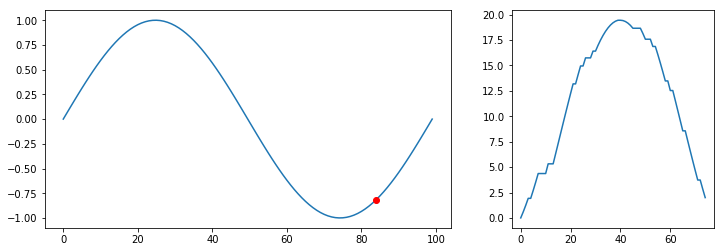

Meta


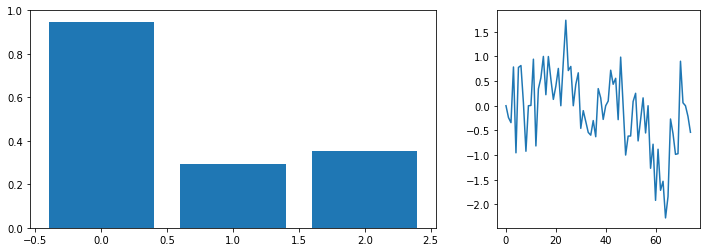

In [67]:
sub_envs = []
for i in range(3):
    sub_envs.append(SubEnvironment())
    
meta_env = MetaEnvironment(sub_envs)
obs = meta_env.reset()

obs = env.reset()
done = False
i = 0
while not done:
    action = meta_env.action_space.sample()
    obs, rew, done, info = meta_env.step(action)
    i += 1
    if (i + 1) % 25 == 0:
        meta_env.render()

## MetaAgent

In [ ]:
# TODO: Start here

In [ ]:
class SubAgent:
    def __init__(self, env,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        # K.clear_session()
        self.env = env
        
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 
        self.critic = self.build_critic()
        
        # When we want predictions of actions, we need to pass in three things:
        # the observation, the old prob, and the advantage.
        # Here, we just created data to spoof the last two.
        self.DUMMY_ACTION, self.DUMMY_VALUE = np.zeros((1,self.action_space.n)), np.zeros((1,1))

    def proximal_policy_optimization_loss(self, advantage, old_pred, debug=True):
        
        # Defines the PPO loss to be used during actor optimization
        def loss(y_true, y_pred):
            
            # advantage is a vector of size 1 passed in from the critic
            # This summing flattens it
            adv = K.sum(advantage, axis=1)
            if debug:
                adv = K.print_tensor(adv, 'advantage     :')

            # y_true is one-hot vector denoting the action taken
            # y_pred is the output of the actor neural network
            # for the given observation
            # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
            # so prob = y_true * y_pred = [0, 0.5, 0]
            if debug:
                y_true = K.print_tensor(y_true, 'y_true        :')
                y_pred = K.print_tensor(y_pred, 'y_pred        :')
                
            prob = y_true * y_pred
            if debug:
                prob = K.print_tensor(prob, 'prob          :')

            # old_pred is the actor's previous probabilty distribution
            # for the given observation
            # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
            # so prob = y_true * old_pred = [0, 0.4, 0]
            old_prob = y_true * old_pred
            if debug:
                old_prob = K.print_tensor(old_prob, 'old_prob      :')

            # r is the ratio of the old probability to the new one
            # e.g., r = prob/old_prob = [0, 0.5/0.4, 0]
            r = K.sum(prob/(old_prob + 1e-10), axis=1)
            if debug:
                r = K.print_tensor(r, 'r             :')

            # clipped is the value of r clipped between 1 +/- epsilon
            # e.g., r = 1.4, epsilon = 0.2 => clipped = 1.2
            clipped = K.clip(r, min_value=1-self.epsilon, max_value=1+self.epsilon)
            if debug:
                clipped = K.print_tensor(clipped, 'clipped       :')

            # minimum is the min of r * advantage and clipped * advantage
            minimum = K.minimum(r * adv, clipped * adv)
            if debug:
                minimum = K.print_tensor(minimum, 'minimum       :')

            # entropy bonus (to encourage exploration)
            entropy_bonus = self.entropy_loss * (prob * K.log(prob + 1e-10))
            entropy_bonus = K.sum(entropy_bonus, axis=1)
            if debug:
                entropy_bonus = K.print_tensor(entropy_bonus, 'entropy_bonus :')

            # K.mean computes the mean over all dimensions (left with a scaler)
            result = -K.mean(minimum + entropy_bonus)
            if debug:
                result = K.print_tensor(result, 'result        :')

            return result
        return loss
    
    def build_actor(self):
        # actor has three inputs: the current state, the advantage,
        # and the agent's predicted probability for the given observation
        state_inputs = Input(shape=self.observation_space.shape)
        advantage = Input(shape=(1,))
        old_pred = Input(shape=(self.action_space.n,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # the output is a probability distribution over the actions
        out_actions = Dense(self.action_space.n, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_pred],
                      outputs=[out_actions])
        
        # compile the model using our custom loss function
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_pred=old_pred
                      )])
        return model
    
    def build_critic(self):
        # critic recieves the observation as input
        state_inputs = Input(shape=self.observation_space.shape)
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # we predict the value of the current observation
        # i.e., cumulative discounted reward
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict([np.array([observation]), 
                                   self.DUMMY_VALUE, 
                                   self.DUMMY_ACTION])
        prob = prob.flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.action_space.n, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.action_space.n)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_probs = probs
        
        # Calculate advantages
        values = self.critic.predict(obs).reshape((self.buffer_size, 1))
        advs = rews - values
            
        # Train the actor and critic on the batch data
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=self.batch_size, shuffle=True,
                        epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False):
        episode = 0
        reward_history = []

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                action, action_vector, prob = self.get_action(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(action)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['action_vector'].append(action_vector)
                tmp_batch['probability'].append(prob)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                        tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        act = tmp_batch['action_vector'][i]
                        prob = tmp_batch['probability'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['action_vector'].append(act)
                        batch['probability'].append(prob)
                        batch['reward'].append(r)

                    # every 10th episode, log some stuff
                    if (episode+1) % 10 == 0 and verbose:
                        print('Episode:', episode)
                        print('Reward :', reward_data)
                        print('Average:', np.mean(reward_history[-100:]))
                        print('-'*10)
                        print()

                        env.render()
                
                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'action_vector': [],
                        'probability': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1

            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['action_vector'])
            probabilities = np.array(batch['probability'])
            rewards = np.array(batch['reward'])    
            rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, probabilities, rewards)
                    
        self.reward_history = reward_history
        return self.reward_history

In [ ]:
class MetaAgent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-2, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.obs_shape = None
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.coef = 0.01
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 

        self.DUMMY_ALLOCATION, self.DUMMY_VALUE = np.zeros((1, self.n_actions)), np.zeros((1, self.n_obs))

    def proximal_policy_optimization_loss(self, advantage, debug=True):
        def loss(y_true, y_pred):
            y_pred = K.print_tensor(y_pred, 'pred ')
            adv = K.print_tensor(advantage, 'adva ')
            return -self.coef*adv*y_pred + self.entropy_loss*y_pred*K.log(y_pred+1e-10)
        return loss
    
    def build_actor(self):
        state_inputs = Input(shape=(self.n_obs*10,),name='observation')
        advantage = Input(shape=(self.n_obs,),name='advantage')
        previous_allocation = Input(shape=(self.n_actions,),name='previous_allocation')

        x = concatenate([state_inputs, previous_allocation])
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, previous_allocation],
                      outputs=[out_actions])
        
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage
                      )])
        return model

    def get_allocation(self, obs, prev_alloc):
        obs = np.array([obs.flatten()])
        p_al = np.array([prev_alloc])
        alloc = self.actor.predict([obs, self.DUMMY_VALUE, p_al])
        if print_log:
            print('get_allocation')
            print('obs shape:', obs.shape)
            print('DUMMY shape:', self.DUMMY_VALUE.shape)
            print('alloc shape:', alloc.shape)
            print()
        return alloc
    
    def train_batch(self, observations, allocations, rewards, previous_allocations):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        allocs = allocations[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        prev_allocs = previous_allocations[:self.buffer_size]
        
        if print_log:
            print('train_batch:')
            print('obs Shape:', obs.shape)
            print('allocs Shape:', allocs.shape)
            print('rews Shape:', rews.shape)
            print()
        
        self.actor.fit([obs, rews, prev_allocs], [allocs],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False, test_run=False):
        episode = 0
        reward_history = []
        end_test=False
        self.obs_shape = env.shape

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'allocation_vector': [],
                'previous_allocation_vector': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'allocation_vector': [],
                'previous_allocation_vector': [],
                'reward': []
            }
            
            previous_alloc_vector = env.allocation
            tmp_batch['previous_allocation_vector'].append(previous_alloc_vector)

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size and not end_test:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                observation = np.array(observation)
                
                alloc_vector = self.get_allocation(observation, previous_alloc_vector)[0]

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(alloc_vector)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['allocation_vector'].append(alloc_vector)
                tmp_batch['previous_allocation_vector'].append(previous_alloc_vector)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation
                previous_alloc_vector = alloc_vector
                
                if test_run:
                    env.render()

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    # for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                    #     tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        alloc = tmp_batch['allocation_vector'][i]
                        previous_alloc = tmp_batch['previous_allocation_vector'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs.flatten())
                        batch['allocation_vector'].append(alloc)
                        batch['previous_allocation_vector'].append(previous_alloc)
                        batch['reward'].append(r)

                    # every 10th episode, log some stuff
                    if (episode % 100 == 0 or episode == episodes - 1):
                        print('Episode:', episode)
                        print('Reward :', reward_data)
                        print('Average:', np.mean(reward_history[-100:]))
                        print('-'*10)
                        print()
                        env.render()

                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'allocation_vector': [],
                        'previous_allocation_vector': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1
                    
                    if test_run:
                        end_test = True

            if test_run:
                break
                
            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            allocs = np.array(batch['allocation_vector'])
            prev_allocs = np.array(batch['previous_allocation_vector'])
            rewards = np.array(batch['reward'])    
            #rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, allocs, rewards, prev_allocs)
                    
        self.reward_history = reward_history
        return self.reward_history

In [ ]:
K.clear_session()